THIS NOTEBOOK CONTAINS GLOVE EMBEDDING MODELS
1. LSTM 
2. BI-LSTM 
3. BILSTM + BATCH NORMALIZATION

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow


from tensorflow.python.keras.models import Input,Model,Sequential
from tensorflow.keras.layers import Input, Dense, LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,Concatenate,Bidirectional

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
from tensorflow.keras.layers import concatenate

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load train_stances.csv and train_bodies.csv into dataframes
train_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_train.csv")
test_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_test.csv")
valid_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_validation.csv")

# Define stop words
stop_words = [
    "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
    "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
    "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
    "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
    "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
    "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
    "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
    "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
    "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
    "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
    "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
    "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
    "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
    "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
    "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
    "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
    "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
    "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
    "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
    "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
    "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
]

# Remove stopwords from Headline and articleBody columns
train_df["Headline"] = train_df["Headline"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
train_df["articleBody"] = train_df["articleBody"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
test_df["Headline"] = test_df["Headline"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
test_df["articleBody"] = test_df["articleBody"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
valid_df["Headline"] = valid_df["Headline"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
valid_df["articleBody"] = valid_df["articleBody"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


In [6]:
train_df['stance_cat'] = train_df['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
train_df['Stance'].value_counts()

Stance
unrelated    10742
discuss       7127
agree         2942
disagree       672
Name: count, dtype: int64

In [7]:
test_df['stance_cat'] = test_df['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
test_df['Stance'].value_counts()

Stance
unrelated    1342
discuss       891
agree         368
disagree       84
Name: count, dtype: int64

In [9]:
valid_df['stance_cat'] = valid_df['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
valid_df['Stance'].value_counts()

Stance
unrelated    1343
discuss       891
agree         368
disagree       84
Name: count, dtype: int64

In [10]:
corpus = np.r_[train_df['Headline'].values,train_df['articleBody'].values]
print(49972*2)
print(len(corpus)) # first 49972 contains the Headline and next 49972 contains the articleBody

vocabulary = []
for sentence in corpus:
    vocabulary.extend(sentence.split(' '))

vocabulary = list(set(vocabulary))
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))

99944
42966
Vocabulary Length is 22997


In [11]:
max_features = 5000
MAX_NB_WORDS = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 64

In [12]:
GLOVE_DIR = "/kaggle/input/glove50d/glove.6B.50d.txt"
def setup_embedding_index():
    embedding_index=dict()
    f = open(GLOVE_DIR,encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:],dtype='float32')
        embedding_index[word] = coefs
    f.close()
    return embedding_index
embeddings_index = setup_embedding_index()

In [13]:
print(len(embeddings_index['the']))

50


In [14]:

def preprocess_text(data, max_features, max_len, embeddings_index):
    # Tokenize headlines
    tokenizer_headline = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
    tokenizer_headline.fit_on_texts(data.loc[:,'Headline'].values)
    vocab_headline_length = len(tokenizer_headline.word_index) + 1

    # Encode and pad headlines
    encoded_docs_headline = tokenizer_headline.texts_to_sequences(data.loc[:,'Headline'].values)
    padded_docs_headline = pad_sequences(encoded_docs_headline, maxlen=16, padding='post')

    # Tokenize article bodies
    tokenizer_body = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
    tokenizer_body.fit_on_texts(data.loc[:, 'articleBody'].values)
    vocab_body_length = len(tokenizer_body.word_index) + 1

    # Encode and pad article bodies
    encoded_docs_body = tokenizer_body.texts_to_sequences(data.loc[:, 'articleBody'].values)
    padded_docs_body = pad_sequences(encoded_docs_body, maxlen=48, padding='post')

    # Generate embedding matrix for headline
    embedding_matrix_headline = np.zeros((vocab_headline_length, EMBEDDING_DIM))
    for word, i in tokenizer_headline.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_headline[i] = embedding_vector

    # Generate embedding matrix for body
    embedding_matrix_body = np.zeros((vocab_body_length, EMBEDDING_DIM))
    for word, i in tokenizer_body.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_body[i] = embedding_vector

    return padded_docs_headline, padded_docs_body, embedding_matrix_headline, embedding_matrix_body, tokenizer_headline, tokenizer_body, vocab_headline_length, vocab_body_length

# Usage example
max_features = 5000  # Maximum number of words to keep based on frequency
max_len = 64  # Maximum length of sequences
EMBEDDING_DIM = 50  # Dimension of pre-trained word embeddings

# Assuming 'train_df' and 'embeddings_index' are available
train_padded_headline, train_padded_body, train_embedding_headline, train_embedding_body, tokenizer_headline, tokenizer_body, vocab_headline_length, vocab_body_length= preprocess_text(train_df, max_features, max_len, embeddings_index)
MAX_NB_WORDS = 24000

In [15]:
X_valid_headline = tokenizer_headline.texts_to_sequences(valid_df.loc[:,'Headline'].values)
X_test_headline = tokenizer_headline.texts_to_sequences(test_df.loc[:,'Headline'].values)
valid_padded_headline  = pad_sequences(X_valid_headline, maxlen=16, padding='post')
test_padded_headline  = pad_sequences(X_test_headline, maxlen=16, padding='post')


In [23]:
X_valid_body = tokenizer_headline.texts_to_sequences(valid_df.loc[:,'articleBody'].values)
X_test_body = tokenizer_headline.texts_to_sequences(test_df.loc[:,'articleBody'].values)
valid_padded_body = pad_sequences(X_valid_body, maxlen=48, padding='post')
test_padded_body  = pad_sequences(X_test_body, maxlen=48, padding='post')


In [24]:
vocab_body_length

22841

## LSTM Model Architecture

In [46]:
input_headline = Input(shape=(16,), name='input_headline')
input_body = Input(shape=(48,), name='input_body')

# Embedding layers
embedding_headline = Embedding(input_dim=vocab_headline_length, output_dim=50, input_shape=(16,))(input_headline)
embedding_body = Embedding(input_dim=vocab_body_length, output_dim=50, input_shape=(48,))(input_body)

# Concatenate embedding layers
additional_layer = Concatenate(axis=1)([embedding_headline, embedding_body])

# LSTM layer
lstm = LSTM(64)(additional_layer)

# Dropout layer
drop = Dropout(0.25)(lstm)

# Output layer
output = Dense(4, activation='softmax')(drop)

# Create model
model = tensorflow.keras.Model(inputs=[input_headline, input_body], outputs=output)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(**kwargs)


In [49]:
model.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])

In [50]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_headline      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_body          │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 16, 50)    │    149,850 │ input_headline[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 48, 50)    │  1,142,050 │ input_body[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 50)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     29,440 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,321,600 (5.04 MB)

 Trainable params: 1,321,600 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

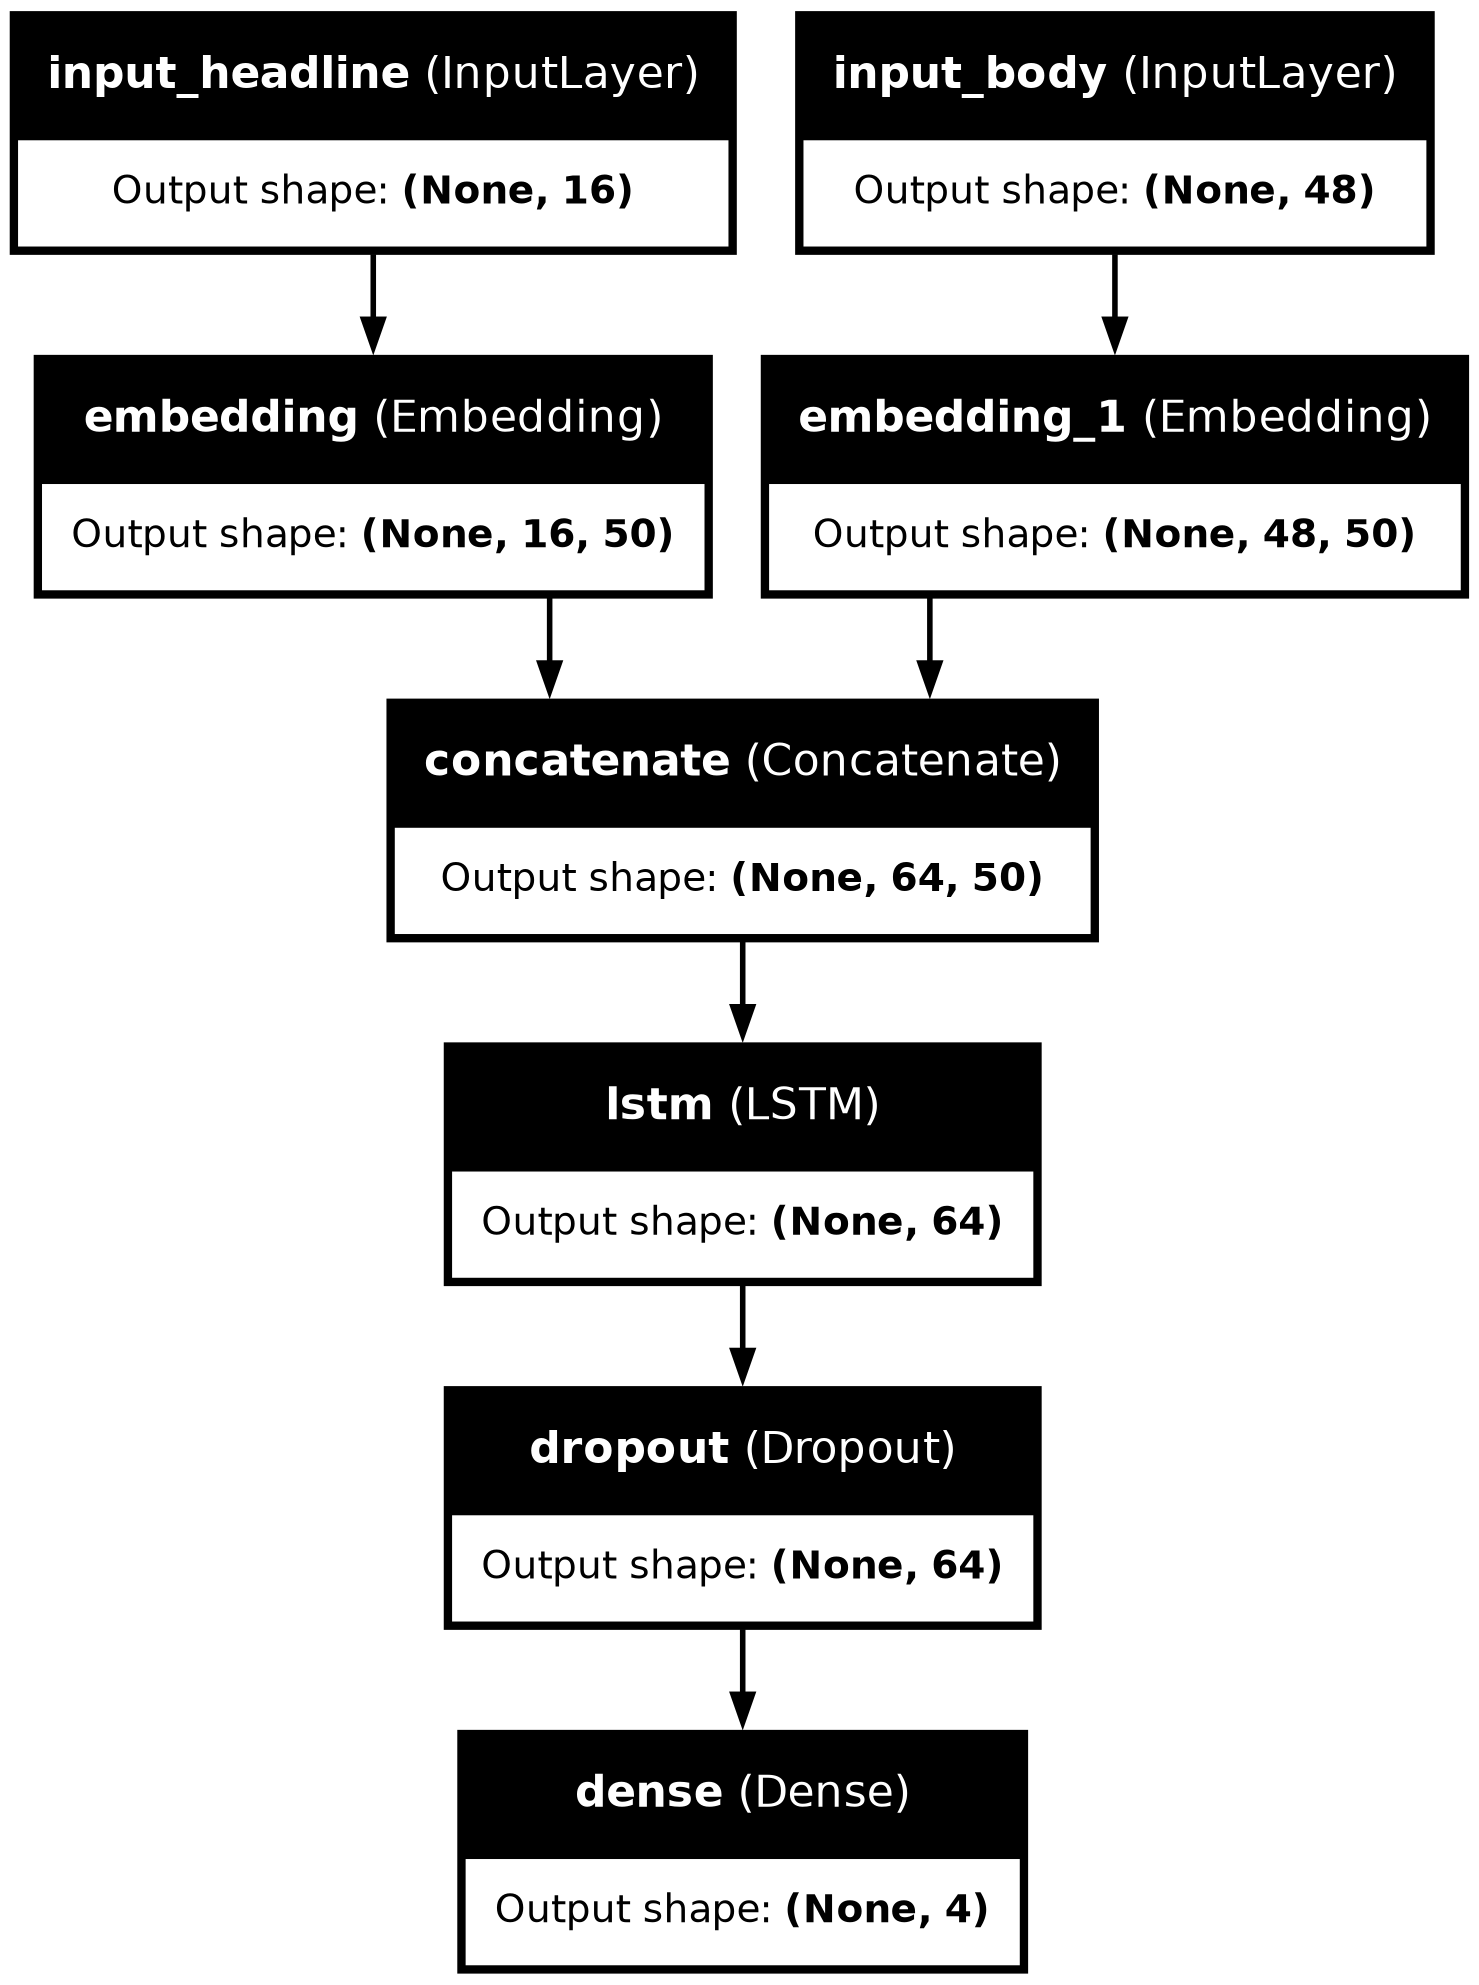

In [51]:
plot_model(model, to_file="model_glove_lstm.png" , show_shapes=True, show_layer_names=True)

In [59]:
labels_train = to_categorical(train_df.loc[:,'stance_cat'])
labels_val = to_categorical(valid_df.loc[:,'stance_cat'])
labels_test = to_categorical(test_df.loc[:,'stance_cat'])

In [164]:
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
seed = 42

# Splitting the data into training, validation, and test sets with stratification
headline_train_val, headline_test, labels_train_val, labels_test = train_test_split(padded_docs_headline, labels, test_size=0.1, random_state=seed, stratify=labels)
headline_train, headline_val, labels_train, labels_val = train_test_split(headline_train_val, labels_train_val, test_size=1/9, random_state=seed, stratify=labels_train_val)

# Similarly for the body data
body_train_val, body_test, _, _ = train_test_split(padded_docs_body, labels, test_size=0.1, random_state=seed, stratify=labels)
body_train, body_val, _, _ = train_test_split(body_train_val, labels_train_val, test_size=1/9, random_state=seed, stratify=labels_train_val)

# Printing the shapes of each set
print("Headline Train Shape:", headline_train.shape)
print("Headline Validation Shape:", headline_val.shape)
print("Headline Test Shape:", headline_test.shape)

print("Body Train Shape:", body_train.shape)
print("Body Validation Shape:", body_val.shape)
print("Body Test Shape:", body_test.shape)

print("Labels Train Shape:", labels_train.shape)
print("Labels Validation Shape:", labels_val.shape)
print("Labels Test Shape:", labels_test.shape)


Headline Train Shape: (21482, 16)

Headline Validation Shape: (2686, 16)

Headline Test Shape: (2686, 16)

Body Train Shape: (21482, 48)

Body Validation Shape: (2686, 48)

Body Test Shape: (2686, 48)

Labels Train Shape: (21482, 4)

Labels Validation Shape: (2686, 4)

Labels Test Shape: (2686, 4)


In [70]:
# model_history = model.fit([train_padded_headline,train_padded_body],labels_train,epochs=40,shuffle=True,verbose=1,
#                           validation_data=([valid_padded_headline,valid_padded_body],labels_val)
#                                           )
model_history = model.fit([train_padded_headline,train_padded_body],labels_train,epochs=40,shuffle=True,verbose=1,
                          validation_split=0.2)                    
                                          

Epoch 1/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9959 - loss: 0.0183 - val_accuracy: 0.9521 - val_loss: 0.2322

Epoch 2/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9959 - loss: 0.0152 - val_accuracy: 0.9493 - val_loss: 0.2317

Epoch 3/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9957 - loss: 0.0154 - val_accuracy: 0.9455 - val_loss: 0.2584

Epoch 4/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9981 - loss: 0.0066 - val_accuracy: 0.9504 - val_loss: 0.2770

Epoch 5/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9970 - loss: 0.0104 - val_accuracy: 0.9488 - val_loss: 0.2510

Epoch 6/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9969 - loss: 0.0114 - val_accuracy: 0.9425 - val_loss: 0.2958

Epoch 7/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9973 - loss: 0.0110 - val_accuracy: 0.9490 - val_loss: 0.2639

Epoch 8/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9969 - loss: 0.0131 - v

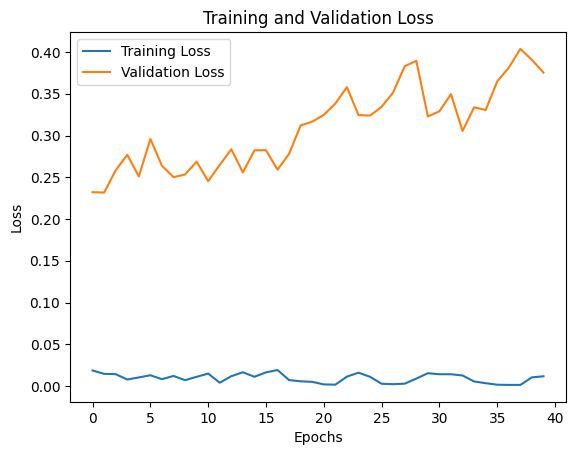

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4620 - loss: 3.1185

Test Loss: 3.1376774311065674

Test Accuracy: 0.4655493497848511


In [71]:
import matplotlib.pyplot as plt

# Train the model with training and validation sets

# Save the training history
training_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

# Plot the loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Evaluate the model on the test set
loss, accuracy = model.evaluate([test_padded_headline, test_padded_body], labels_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)



84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


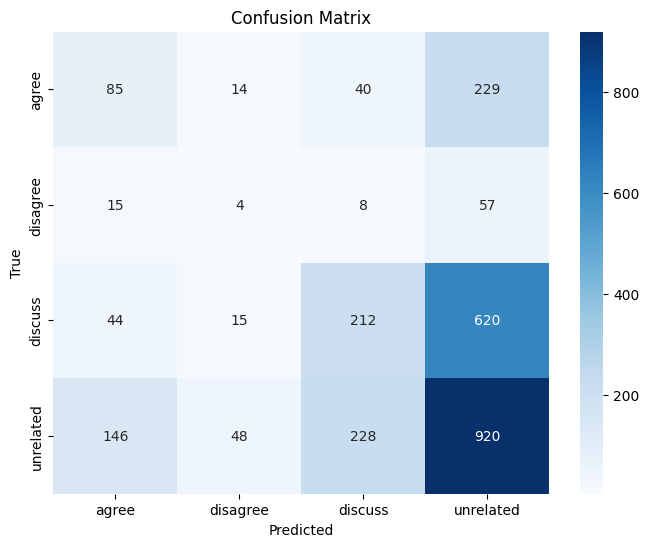

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'model_combined' is your trained model

# Get predictions on the test set
predictions = model.predict([test_padded_headline, test_padded_body])
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels_test.argmax(axis=1), predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [63]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy = accuracy_score(labels_test.argmax(axis=1), predicted_labels)

# Calculate precision, recall, F1-score using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels, average='weighted')

# Define your custom score function
def score_submission(gold_labels, test_labels):
    score = 0.0

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25


    return score


def report_score(actual,predicted):
    score = score_submission(actual,predicted)
    best_score = score_submission(actual,actual)

    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


# Calculate your custom score
custom_score = score_submission(labels_test.argmax(axis=1), predicted_labels)
report_sc = report_score(labels_test.argmax(axis=1), predicted_labels)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score)


Score: 1025.0 out of 2349.5	(43.62630346882315%)

Custom Score: 1025.0


In [64]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score for each class using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels, average=None)

# Print class-wise F1 scores
for i in range(len(precision)):
    print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1_score[i]}")

# Print all the metrics
print("Accuracy:", accuracy)
print("Macro Precision:", precision.mean())
print("Macro Recall:", recall.mean())
print("Macro F1 Score:", f1_score.mean())
print("Custom Score:", custom_score)


Class 0 - Precision: 0.29310344827586204, Recall: 0.23097826086956522, F1-score: 0.2583586626139817

Class 1 - Precision: 0.04938271604938271, Recall: 0.047619047619047616, F1-score: 0.04848484848484848

Class 2 - Precision: 0.4344262295081967, Recall: 0.23793490460157127, F1-score: 0.3074691805656273

Class 3 - Precision: 0.5038335158817087, Recall: 0.6855439642324889, F1-score: 0.5808080808080808

Accuracy: 0.4547486033519553

Macro Precision: 0.32018647742878753

Macro Recall: 0.30051904433066823

Macro F1 Score: 0.29878019311813453

Custom Score: 1025.0


## BILSTM

In [79]:
input_headline = Input(shape=(16,), name='input_headline')
input_body = Input(shape=(48,), name='input_body')

# Embedding layers
embedding_headline = Embedding(input_dim=vocab_headline_length, output_dim=50, input_shape=(16,))(input_headline)
embedding_body = Embedding(input_dim=vocab_body_length, output_dim=50, input_shape=(48,))(input_body)

# Concatenate embedding layers
additional_layer = Concatenate(axis=1)([embedding_headline, embedding_body])

# LSTM layer
lstm = Bidirectional(LSTM(64))(additional_layer)

# Dropout layer
drop = Dropout(0.5)(lstm)

# Output layer
output = Dense(4, activation='sigmoid')(drop)

# Create model
model_bidirectional = tensorflow.keras.Model(inputs=[input_headline, input_body], outputs=output)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(**kwargs)


In [80]:
model_bidirectional.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])
model_bidirectional.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_headline      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_body          │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 16, 50)    │    149,850 │ input_headline[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 48, 50)    │  1,142,050 │ input_body[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 50)    │          0 │ embedding_2[0][0… │
│ (Concatenate)       │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     58,880 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,351,296 (5.15 MB)

 Trainable params: 1,351,296 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

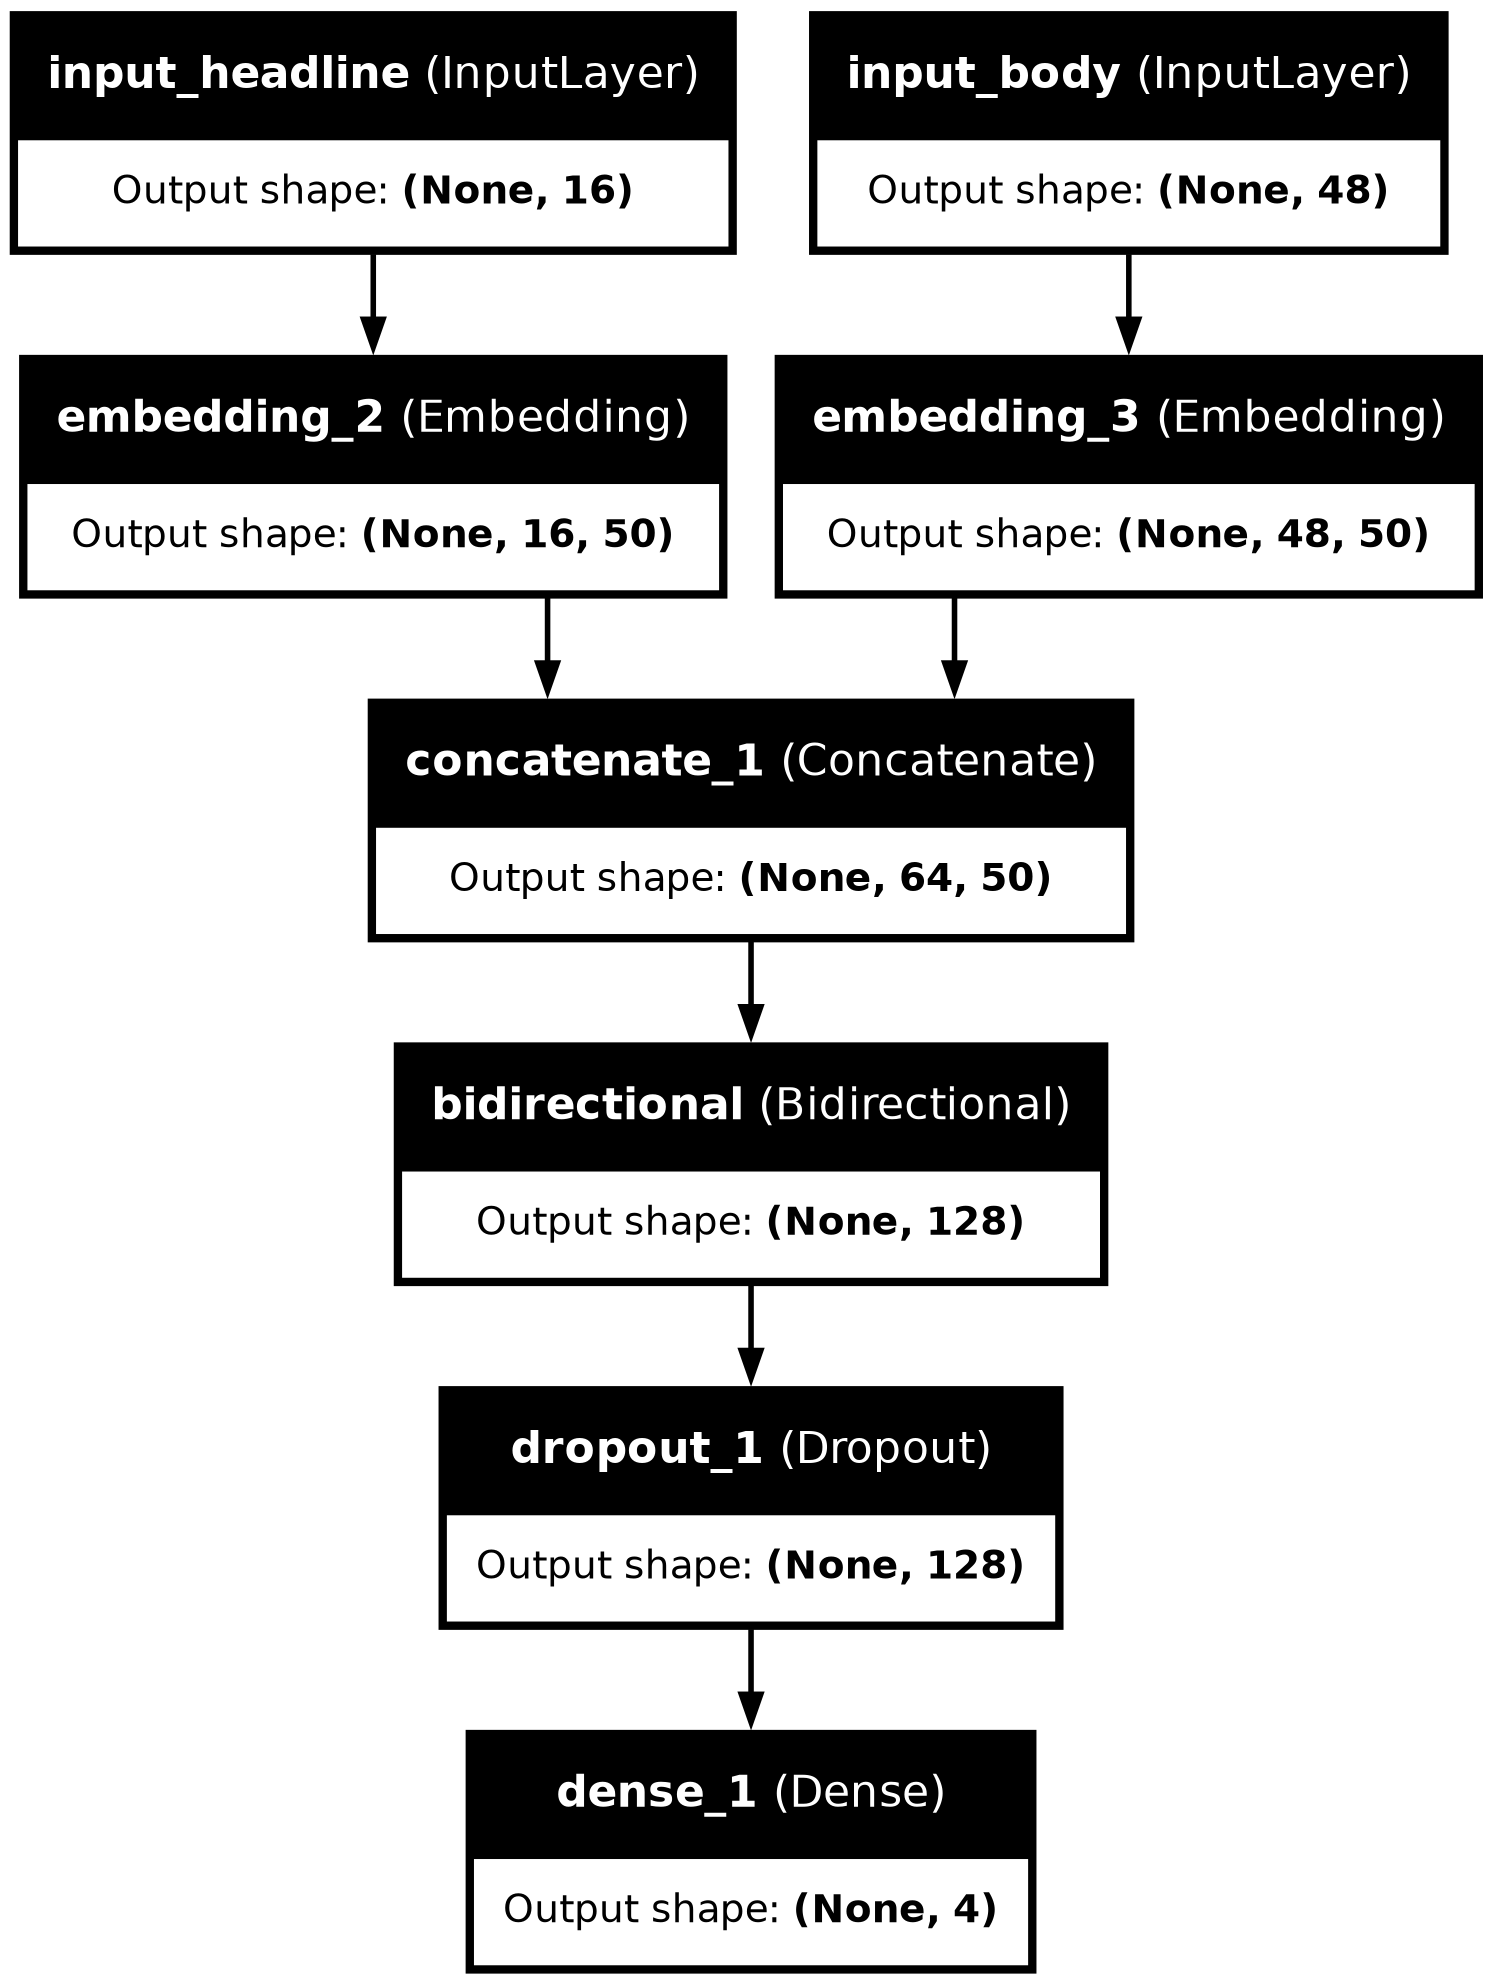

In [81]:
plot_model(model_bidirectional, to_file='model_glove_bi_lstm.png', show_shapes=True, show_layer_names=True)

In [83]:
# model_bidirectional_history = model_bidirectional.fit([headline_train,body_train],labels_train,epochs=40,shuffle=True,verbose=1,
#                           validation_data=([headline_val,body_val],labels_val)
#                                           )
model_bidirectional_history = model_bidirectional.fit([train_padded_headline,train_padded_body],labels_train,epochs=40,shuffle=True,verbose=1,
                          validation_split=0.2)  

Epoch 1/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5370 - loss: 1.0560 - val_accuracy: 0.6849 - val_loss: 0.7358

Epoch 2/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7115 - loss: 0.6678 - val_accuracy: 0.7217 - val_loss: 0.6543

Epoch 3/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7680 - loss: 0.5488 - val_accuracy: 0.7363 - val_loss: 0.6373

Epoch 4/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7853 - loss: 0.4874 - val_accuracy: 0.7638 - val_loss: 0.5883

Epoch 5/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8271 - loss: 0.4125 - val_accuracy: 0.7908 - val_loss: 0.5472

Epoch 6/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8487 - loss: 0.3613 - val_accuracy: 0.7999 - val_loss: 0.5324

Epoch 7/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8767 - loss: 0.3060 - val_accuracy: 0.8150 - val_loss: 0.5199

Epoch 8/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8918 - loss: 0.2727 

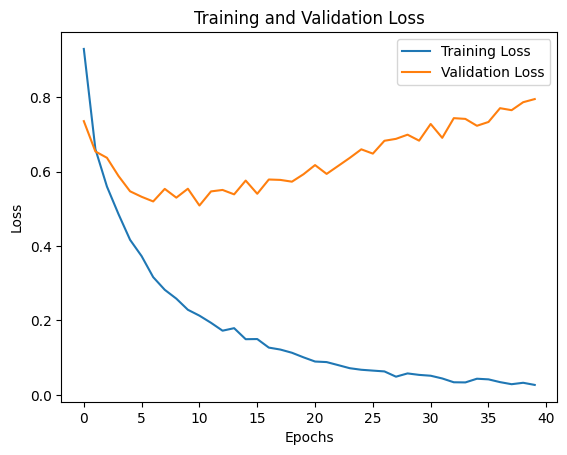

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4631 - loss: 6.0970

Test Loss: 6.098589897155762

Test Accuracy: 0.4670391082763672


In [85]:
# Save the training history
training_loss_bidirectional = model_bidirectional_history.history['loss']
validation_loss_bidirectional = model_bidirectional_history.history['val_loss']

# Plot the loss
plt.plot(training_loss_bidirectional, label='Training Loss')
plt.plot(validation_loss_bidirectional, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_bidirectional, accuracy_bidirectional = model_bidirectional.evaluate([test_padded_headline, test_padded_body], labels_test)
print('Test Loss:', loss_bidirectional)
print('Test Accuracy:', accuracy_bidirectional)


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


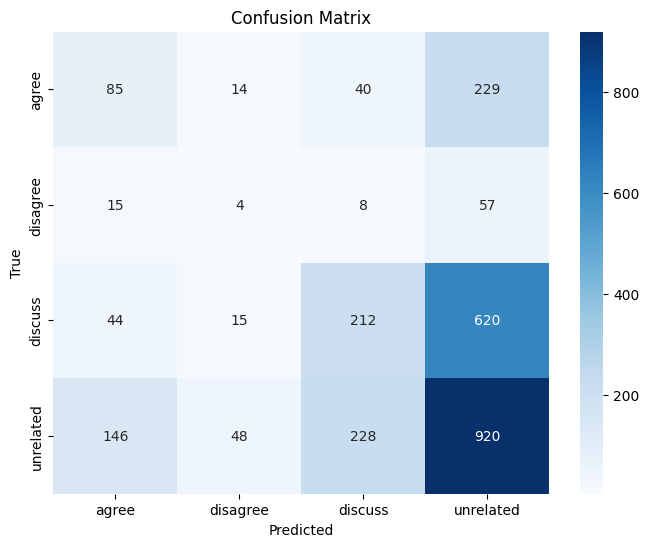

In [87]:
predictions_bidirectional = model_bidirectional.predict([test_padded_headline, test_padded_body])
predicted_labels_bidirectional = np.argmax(predictions_bidirectional, axis=1)

# Compute the confusion matrix
conf_matrix_bidirectional = confusion_matrix(labels_test.argmax(axis=1), predicted_labels_bidirectional)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [88]:
# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy_bidirectional = accuracy_score(labels_test.argmax(axis=1), predicted_labels_bidirectional)

# Calculate precision, recall, F1-score using scikit-learn
precision_bidirectional, recall_bidirectional, f1_score_bidirectional, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels_bidirectional, average='weighted')

# Calculate your custom score
custom_score_bidirectional = score_submission(labels_test.argmax(axis=1), predicted_labels_bidirectional)
report_sc_bidirectional = report_score(labels_test.argmax(axis=1), predicted_labels_bidirectional)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score_bidirectional)

Score: 1047.25 out of 2349.5	(44.57331347095127%)

Custom Score: 1047.25


In [89]:
# Calculate precision, recall, F1-score for each class using scikit-learn
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
precision_bidirectional, recall_bidirectional, f1_score_bidirectional, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels_bidirectional, average=None)

# Print class-wise F1 scores
for i in range(len(precision_bidirectional)):
    print(f"Class {i} - Precision: {precision_bidirectional[i]}, Recall: {recall_bidirectional[i]}, F1-score: {f1_score_bidirectional[i]}")

# Print all the metrics
print("Accuracy:", accuracy_bidirectional)
print("Macro Precision:", precision_bidirectional.mean())
print("Macro Recall:", recall_bidirectional.mean())
print("Macro F1 Score:", f1_score_bidirectional.mean())
print("Custom Score:", custom_score_bidirectional)

Class 0 - Precision: 0.30337078651685395, Recall: 0.22010869565217392, F1-score: 0.2551181102362205

Class 1 - Precision: 0.13114754098360656, Recall: 0.09523809523809523, F1-score: 0.1103448275862069

Class 2 - Precision: 0.42016806722689076, Recall: 0.2244668911335578, F1-score: 0.29261155815654716

Class 3 - Precision: 0.5130249867091973, Recall: 0.7190760059612519, F1-score: 0.5988209742475954

Accuracy: 0.4670391061452514

Macro Precision: 0.3419278453591371

Macro Recall: 0.3147224219962697

Macro F1 Score: 0.3142238675566425

Custom Score: 1047.25


## IMPROVING THE MODEL WITH DROPOUT AND BATCH NORMALIZATION

In [91]:
from tensorflow.keras.layers import Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, LayerNormalization
input_headline = Input(shape=(16,), name='input_headline')
input_body = Input(shape=(48,), name='input_body')

# Embedding layers
embedding_headline = Embedding(input_dim=vocab_headline_length, output_dim=50, input_shape=(16,))(input_headline)
embedding_body = Embedding(input_dim=vocab_body_length, output_dim=50, input_shape=(48,))(input_body)

# Concatenate embedding layers
additional_layer = Concatenate(axis=1)([embedding_headline, embedding_body])

lstm = Bidirectional(LSTM(64))(additional_layer)

# Batch normalization
batch_norm = BatchNormalization()(lstm)

# Dropout layer
drop = Dropout(0.5)(batch_norm)

# Output layer
output = Dense(4, activation='sigmoid')(drop)

model_bidirectional_batchnorm= tensorflow.keras.Model(inputs=[input_headline, input_body], outputs=output)

In [92]:
model_bidirectional_batchnorm.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])
model_bidirectional_batchnorm.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_headline      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_body          │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 16, 50)    │    149,850 │ input_headline[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 48, 50)    │  1,142,050 │ input_body[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 50)    │          0 │ embedding_6[0][0… │
│ (Concatenate)       │                   │            │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │     58,880 │ concatenate_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        516 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,351,808 (5.16 MB)

 Trainable params: 1,351,552 (5.16 MB)

 Non-trainable params: 256 (1.00 KB)

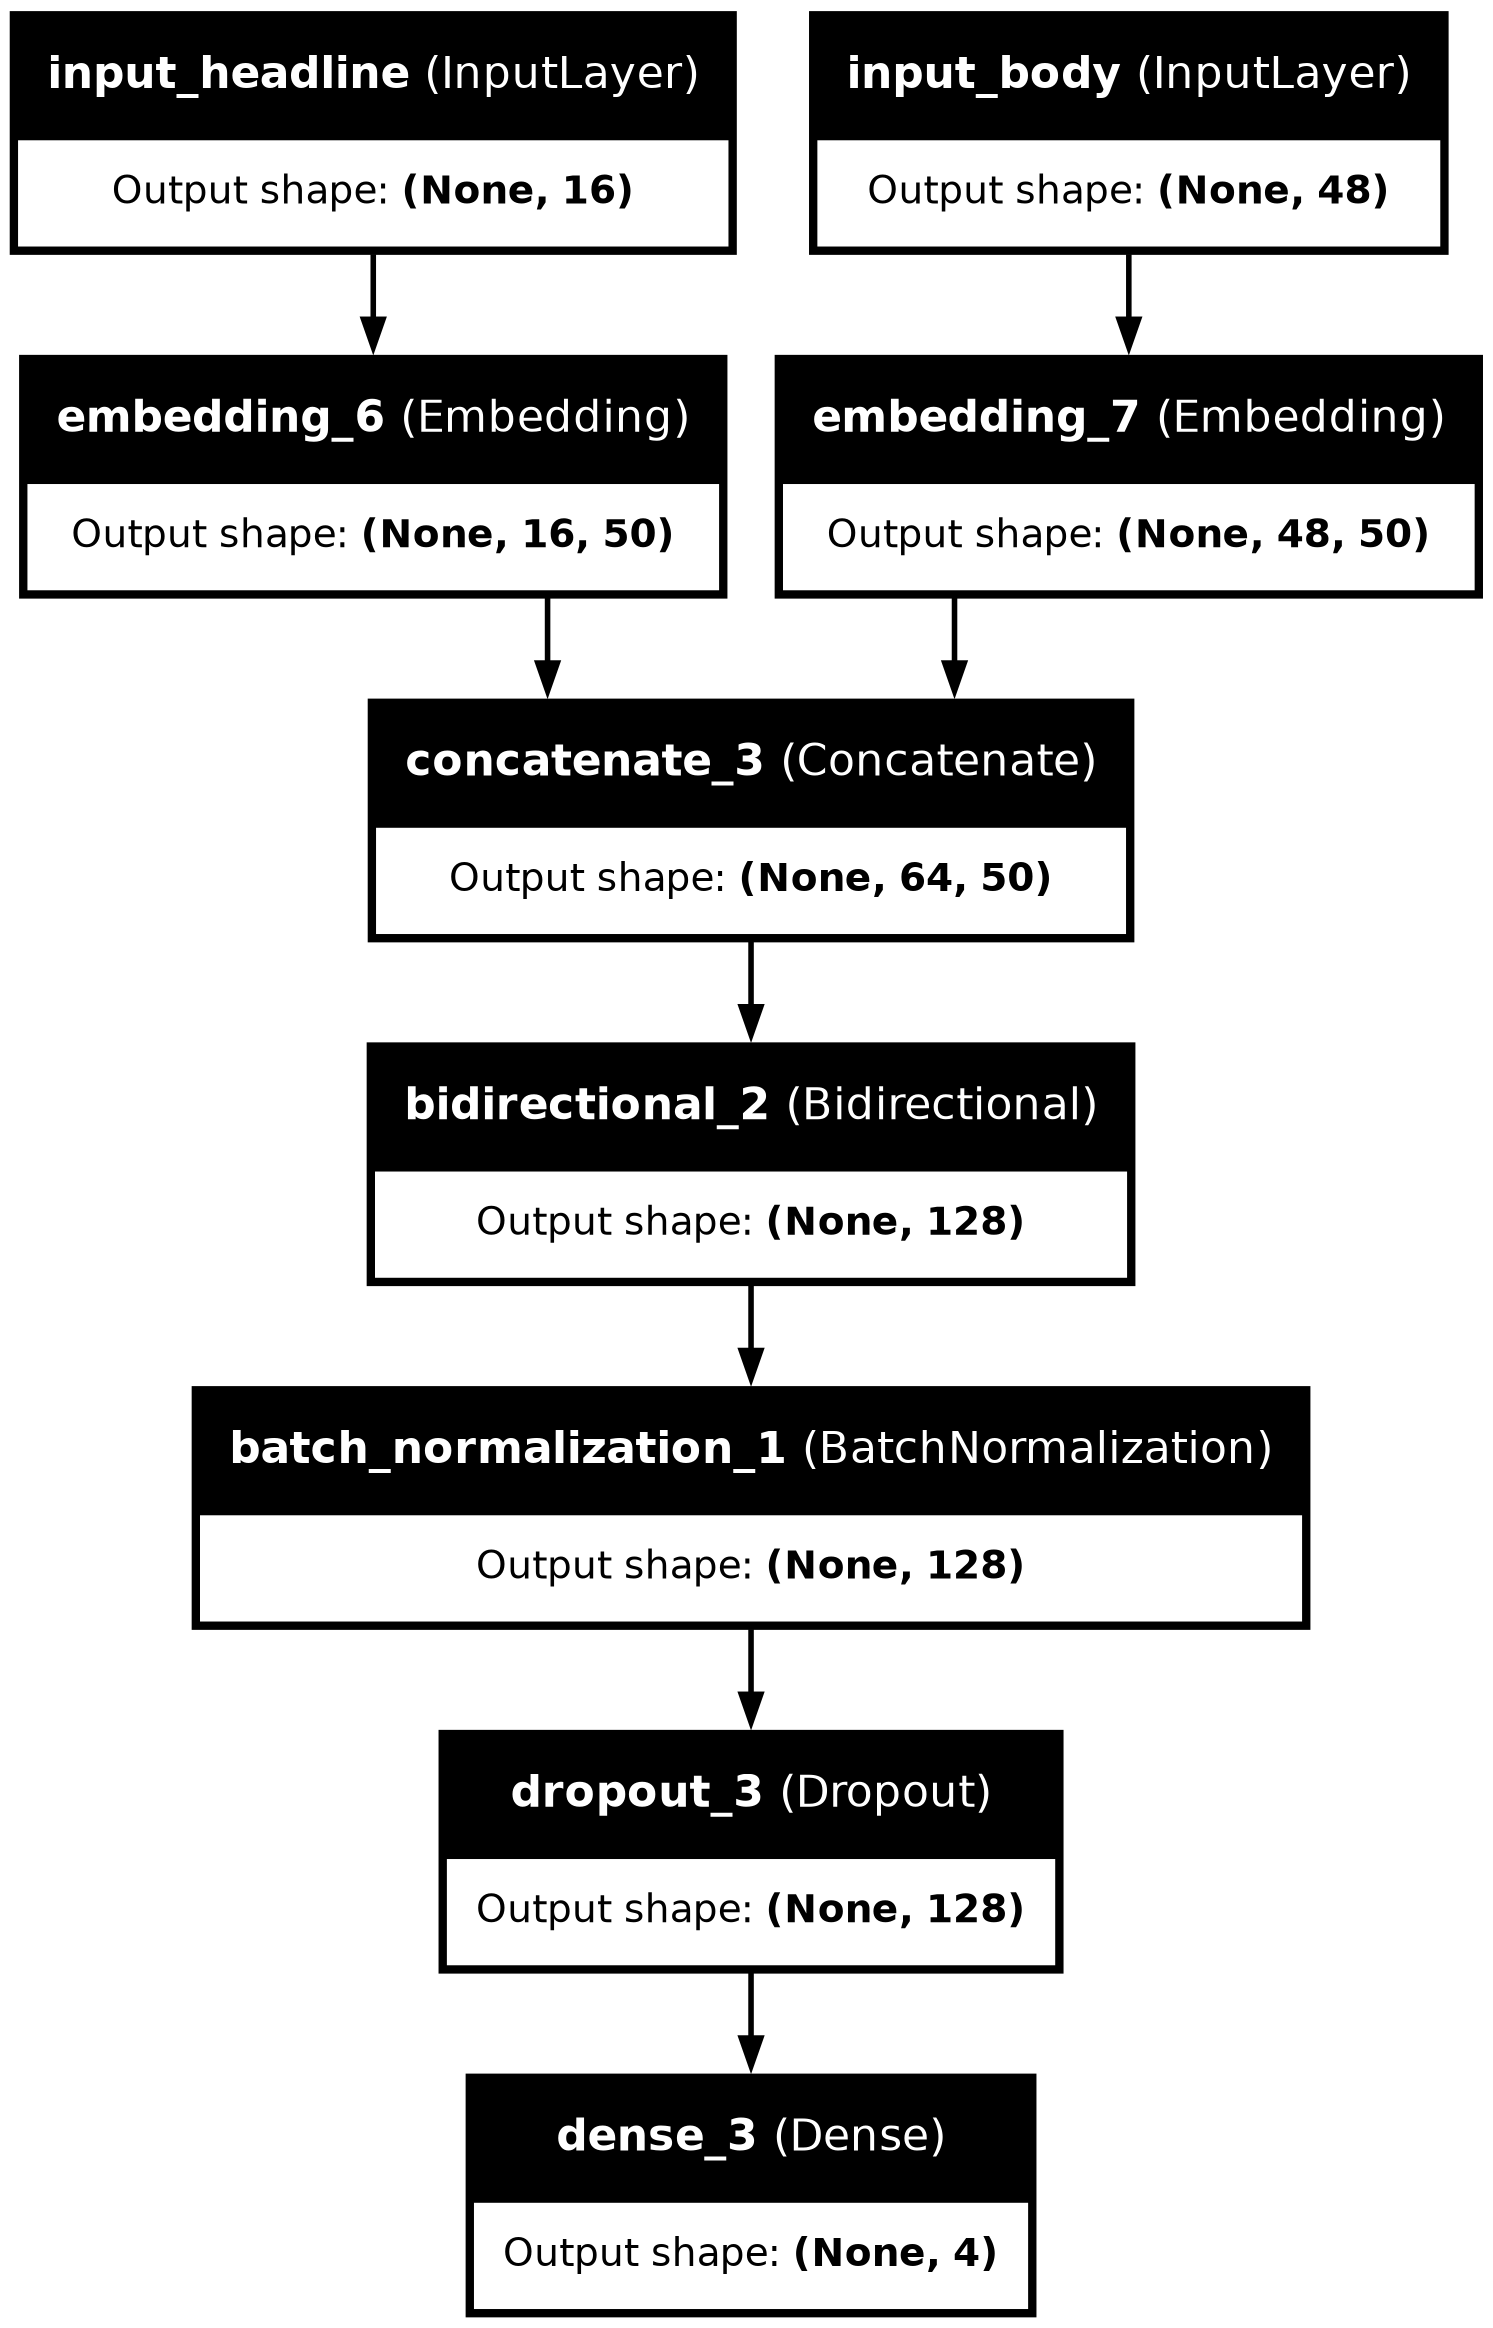

In [93]:
plot_model(model_bidirectional_batchnorm, to_file='model_glove_bi_normal.png', show_shapes=True, show_layer_names=True)

In [94]:

model_bibatch_history = model_bidirectional_batchnorm.fit([train_padded_headline,train_padded_body],labels_train,epochs=40,shuffle=True,verbose=1,
                          validation_split=0.2)  

Epoch 1/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5276 - loss: 1.0706 - val_accuracy: 0.6009 - val_loss: 0.9101

Epoch 2/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7162 - loss: 0.6747 - val_accuracy: 0.6381 - val_loss: 0.8552

Epoch 3/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7544 - loss: 0.5931 - val_accuracy: 0.7210 - val_loss: 0.6688

Epoch 4/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7799 - loss: 0.5390 - val_accuracy: 0.7252 - val_loss: 0.6717

Epoch 5/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7805 - loss: 0.5267 - val_accuracy: 0.7391 - val_loss: 0.6600

Epoch 6/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7896 - loss: 0.5028 - val_accuracy: 0.7324 - val_loss: 0.6602

Epoch 7/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7901 - loss: 0.4864 - val_accuracy: 0.7449 - val_loss: 0.6529

Epoch 8/40

538/538 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8061 - loss: 0.

In [ ]:
labels_test.shape

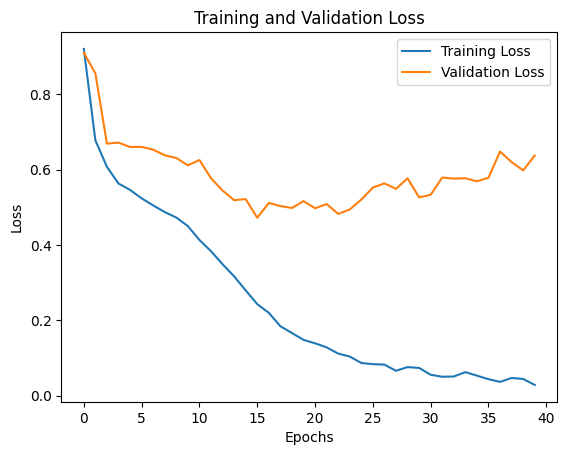

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4425 - loss: 4.7319

Test Loss: 4.50446891784668

Test Accuracy: 0.4595903158187866


In [96]:
# Save the training history
training_loss_binorm = model_bibatch_history.history['loss']
validation_loss_binorm = model_bibatch_history.history['val_loss']

# Plot the loss
plt.plot(training_loss_binorm, label='Training Loss')
plt.plot(validation_loss_binorm, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_binorm, accuracy_binorm = model_bidirectional_batchnorm.evaluate([test_padded_headline, test_padded_body], labels_test)
print('Test Loss:', loss_binorm)
print('Test Accuracy:', accuracy_binorm)


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


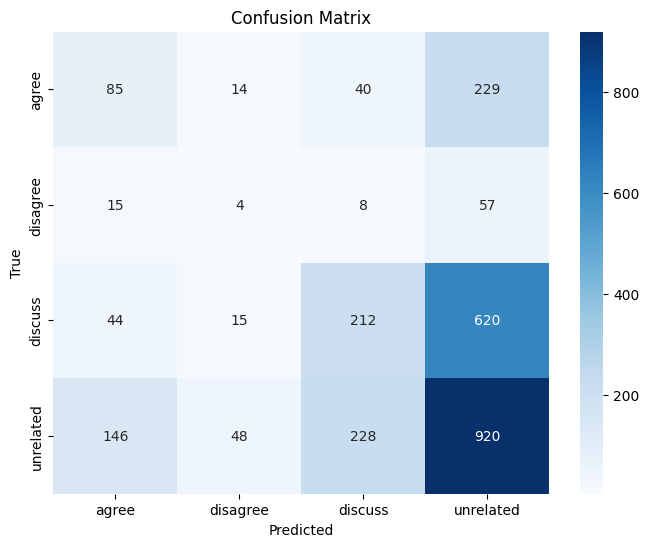

In [98]:
predictions_binorm = model_bidirectional_batchnorm.predict([test_padded_headline, test_padded_body])
predicted_labels_binorm = np.argmax(predictions_binorm, axis=1)

# Compute the confusion matrix
conf_matrix_binorm = confusion_matrix(labels_test.argmax(axis=1), predicted_labels_binorm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [99]:
# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy_binorm= accuracy_score(labels_test.argmax(axis=1), predicted_labels_binorm)

# Calculate precision, recall, F1-score using scikit-learn
precision_binorm, recall_binorm, f1_score_binorm, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels_binorm, average='weighted')

# Calculate your custom score
custom_score_binorm = score_submission(labels_test.argmax(axis=1), predicted_labels_binorm)
report_sc_binorm = report_score(labels_test.argmax(axis=1), predicted_labels_binorm)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score_binorm)

Score: 1045.25 out of 2349.5	(44.488188976377955%)

Custom Score: 1045.25


In [100]:
# Calculate precision, recall, F1-score for each class using scikit-learn
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
precision_binorm, recall_binorm, f1_score_binorm, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels_binorm, average=None)

# Print class-wise F1 scores
for i in range(len(precision_binorm)):
    print(f"Class {i} - Precision: {precision_binorm[i]}, Recall: {recall_binorm[i]}, F1-score: {f1_score_binorm[i]}")

# Print all the metrics
print("Accuracy:", accuracy_binorm)
print("Macro Precision:", precision_binorm.mean())
print("Macro Recall:", recall_binorm.mean())
print("Macro F1 Score:", f1_score_binorm.mean())
print("Custom Score:", custom_score_binorm)

Class 0 - Precision: 0.3032069970845481, Recall: 0.2826086956521739, F1-score: 0.29254571026722925

Class 1 - Precision: 0.16, Recall: 0.09523809523809523, F1-score: 0.11940298507462685

Class 2 - Precision: 0.4058252427184466, Recall: 0.2345679012345679, F1-score: 0.2972972972972973

Class 3 - Precision: 0.5137872819358469, Recall: 0.680327868852459, F1-score: 0.5854440525809554

Accuracy: 0.4595903165735568

Macro Precision: 0.3457048804347104

Macro Recall: 0.323185640244324

Macro F1 Score: 0.3236725113050272

Custom Score: 1045.25
